# Análisis de accidentes 
Hacemos una función que llama a los siguientes elementos llamados indentificador: [`state_name`, `land_use_mane`, `ownership_name`, `trafficway_identifier`], para cada uno hacemos la query hacia `bigquery-public-data.nhtsa_traffic_fatalities.accident_2015`. La función crea un dataframe con los datos exactos del número de accidentes máximo y la hora en que se alcanzó el máximo por cada identificador.     

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from google.cloud import bigquery
client = bigquery.Client(project='bigquery-cursophydata')

def accidents_by_hour(identifier): 
    query = f""" 
    SELECT 
        {identifier},
        EXTRACT(HOUR FROM timestamp_of_crash) AS hour,
        COUNT(*) AS num_accidents
    FROM `bigquery-public-data.nhtsa_traffic_fatalities.accident_2015`
    WHERE {identifier} IN ( 
        SELECT {identifier} 
        FROM( 
            SELECT 
                {identifier}, 
                SUM(number_of_fatalities) AS total_fatalities
            FROM `bigquery-public-data.nhtsa_traffic_fatalities.accident_2015`
            GROUP BY {identifier}
            ORDER BY total_fatalities DESC
            LIMIT 10
        )
    ) 
    GROUP BY {identifier}, hour
    ORDER BY {identifier}, hour
    """
    query_job = client.query(query) 
    results = query_job.result()
    df = results.to_dataframe()
    df.to_csv(f'accidents_by_hour_{identifier}.csv', index=False)

    identifiers = df[f'{identifier}'].unique()
    df_max_acc = pd.DataFrame()
    for identify in identifiers: 
        df_max_acc[str(identify)] = df[df[f'{identifier}'] == identify].max().drop(f'{identifier}')
    return df_max_acc 

In [2]:
accidents_by_hour('state_name')

,California,Florida,Georgia,Illinois,New York,North Carolina,Ohio,Pennsylvania,South Carolina,Texas
hour,23,23,23,23,23,23,23,23,23,23
num_accidents,208,201,86,61,79,81,70,72,59,196


El estado con mayor cantidad de accidentes es California con 208 a las 23:00 hrs.  

In [3]:
accidents_by_hour('land_use_name')

,Not Reported,Rural,Trafficway Not in State Inventory,Unknown,Urban
hour,22,23,23,23,23
num_accidents,2,975,16,4,1072


El tipo de suelo con mayor cantidad de accidentes es el urbano con 1072 a las 23:00 hrs.  

In [4]:
accidents_by_hour('ownership_name')

,City or Municipal Highway Agency,County Highway Agency,Not Reported,Other Federal Agency,Other Local Agency,State Highway Agency,State Toll Road,Town or Township Highway Agency,Trafficway Not in State Inventory,Unknown
hour,23,23,23,22,23,23,23,23,23,23
num_accidents,212,229,415,5,51,893,6,72,16,77


El tipo de agencia con mayor cantidad de accidentes es 'state highway agency' con 893 a las 23:00 hrs.  

In [5]:
accidents_by_hour('trafficway_identifier')

,I-10,I-15,I-20,I-40,I-5,I-70,I-75,I-80,I-95,US-1
hour,23,23,23,23,23,23,23,23,23,23
num_accidents,21,10,13,13,11,12,16,9,15,18


El tipo de identificador de carretera con mayor cantidad de accidentes es la 'I-10' con 21 a las 23:00 hrs.  

### Análisis mensual y por hora de accidentes
Para hacer este análisis utilizamos la misma query anterior pero cambiamos la función, en este caso la función llamará a: ('month' y 'hour'), para que entrege el dataframe de forma mensual o por hora.     

In [6]:
def plotby(period): 
    identifier = 'state_name' 
    query = f""" 
    SELECT 
        {identifier},
        EXTRACT({period.upper()} FROM timestamp_of_crash) AS {period},
        COUNT(*) AS num_accidents
    FROM `bigquery-public-data.nhtsa_traffic_fatalities.accident_2015`
    WHERE {identifier} IN ( 
        SELECT {identifier} 
        FROM( 
            SELECT 
                {identifier}, 
                SUM(number_of_fatalities) AS total_fatalities
            FROM `bigquery-public-data.nhtsa_traffic_fatalities.accident_2015`
            GROUP BY {identifier}
            ORDER BY total_fatalities DESC
            LIMIT 10
        )
    ) 
    GROUP BY {identifier}, {period}
    ORDER BY {identifier}, {period}
    """
    query_job = client.query(query) 
    results = query_job.result()
    df = results.to_dataframe()
    df.to_csv(f'accidents_by_{period}_{identifier}.csv', index=False)
    plt.figure(figsize=(13, 10))
    sns.pointplot(data=df, x=str(period), y='num_accidents', hue='state_name') 
    plt.title('Accidents by ' + str(period) + ' and States, year 2015')

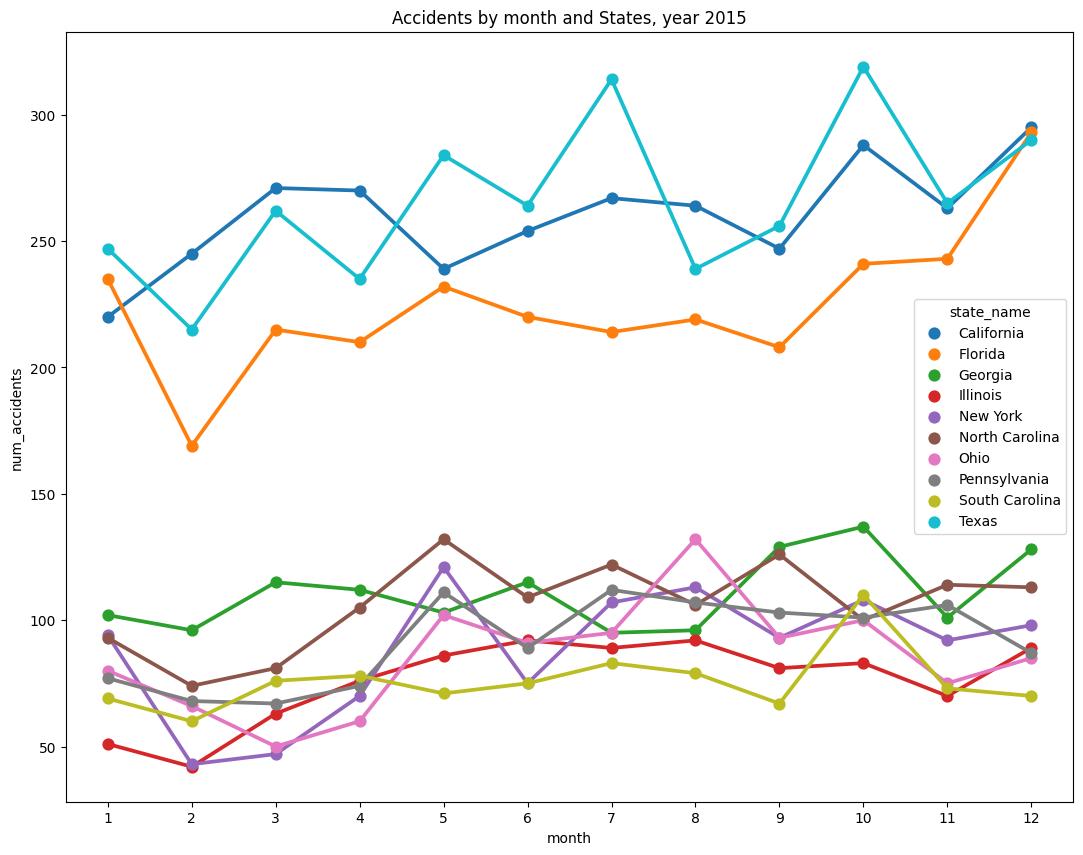

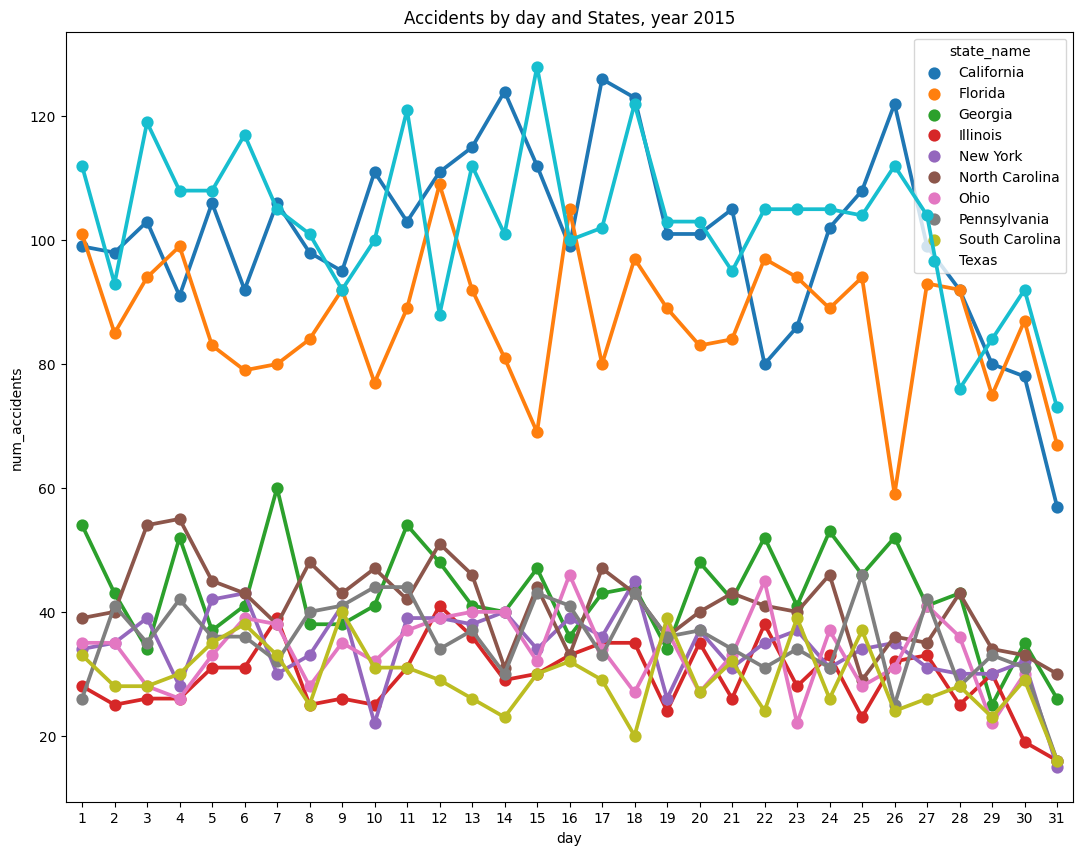

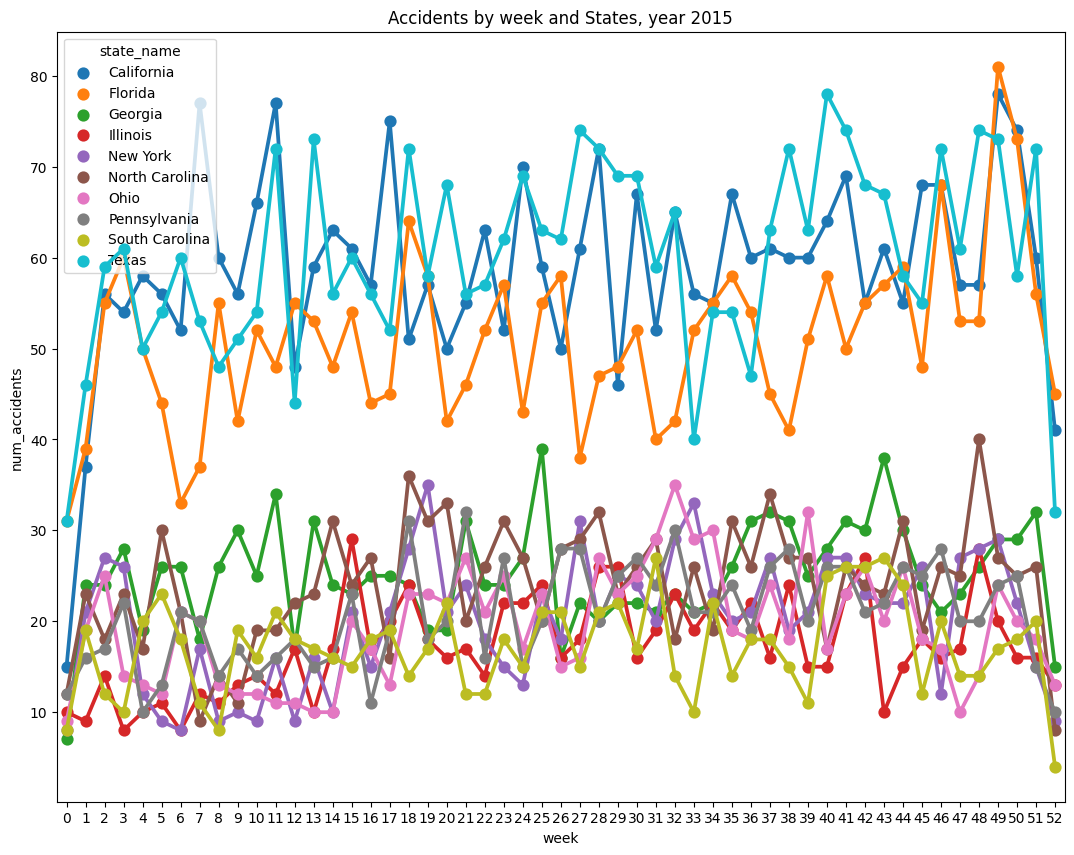

In [7]:
plotby('month')
plotby('day')
plotby('week')

El peor estado desde el punto de vista de la cantidad de accidentes es Texas. También, vemos que los estados Florida, California y Texas tienen una mayor cantidad de accidentes, esto es por la mayor cantidad de habitantes de dichos estados.  

### Accidentes vs conductores ebrios
Vamos a realizar un análisis de la correlación entre la cantidad de accidentes y la ebriedad de los conductores. Creamos un factor de proporcionalidad que nos entregará la proporción de conductores ebrios con respecto al total de accidentes, por año, por mes y por semana.              

In [37]:
def totalfatalities_to_df(period): 
    identifier = 'state_name' 
    query1 = f""" 
    SELECT 
        {identifier},
        EXTRACT({period.upper()} FROM timestamp_of_crash) AS {period},
        COUNT(*) AS num_accidents
    FROM `bigquery-public-data.nhtsa_traffic_fatalities.accident_2015`
    WHERE {identifier} IN ( 
        SELECT {identifier} 
        FROM( 
            SELECT 
                {identifier}, 
                SUM(number_of_fatalities) AS total_fatalities
            FROM `bigquery-public-data.nhtsa_traffic_fatalities.accident_2015`
            GROUP BY {identifier}
            ORDER BY total_fatalities DESC
            LIMIT 10
        )
    ) 
    GROUP BY {identifier}, {period}
    ORDER BY {identifier}, {period}
    """
    df1 = client.query(query1).result().to_dataframe()
 
    query2 = f""" 
    SELECT 
        {identifier},
        EXTRACT({period.upper()} FROM timestamp_of_crash) AS {period},
        SUM(number_of_drunk_drivers) AS drunk_drivers
    FROM `bigquery-public-data.nhtsa_traffic_fatalities.accident_2015`
    WHERE {identifier} IN ( 
        SELECT {identifier} 
        FROM( 
            SELECT 
                {identifier}, 
                SUM(number_of_drunk_drivers) AS drunk_drivers
            FROM `bigquery-public-data.nhtsa_traffic_fatalities.accident_2015`
            GROUP BY {identifier}
            ORDER BY drunk_drivers DESC
            LIMIT 10
        )
    ) 
    GROUP BY {identifier}, {period}
    ORDER BY {identifier}, {period}
    """
    df2 = client.query(query2).result().to_dataframe()
    df1['drunk_drivers'] = df2['drunk_drivers']
    df1['proportion_drunk_drivers'] = df1['drunk_drivers'] / df1['num_accidents']
    return df1  


def plot_drunks_by_accidents(period): 
    plt.figure(figsize=(15, 9))
    sns.pointplot(data=totalfatalities_to_df(period), x=str(period), y='proportion_drunk_drivers', hue='state_name') 
    plt.title('Proportion of drunks by ' + str(period) + ' and States, year 2015')

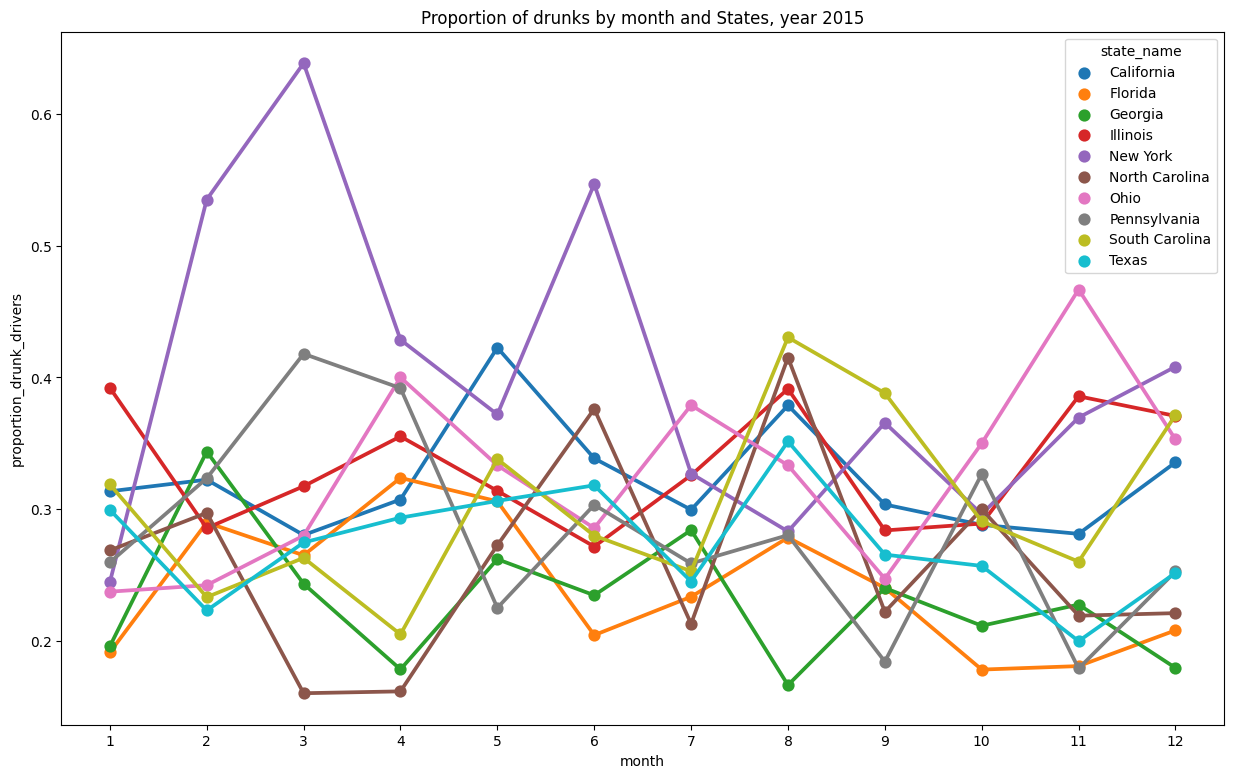

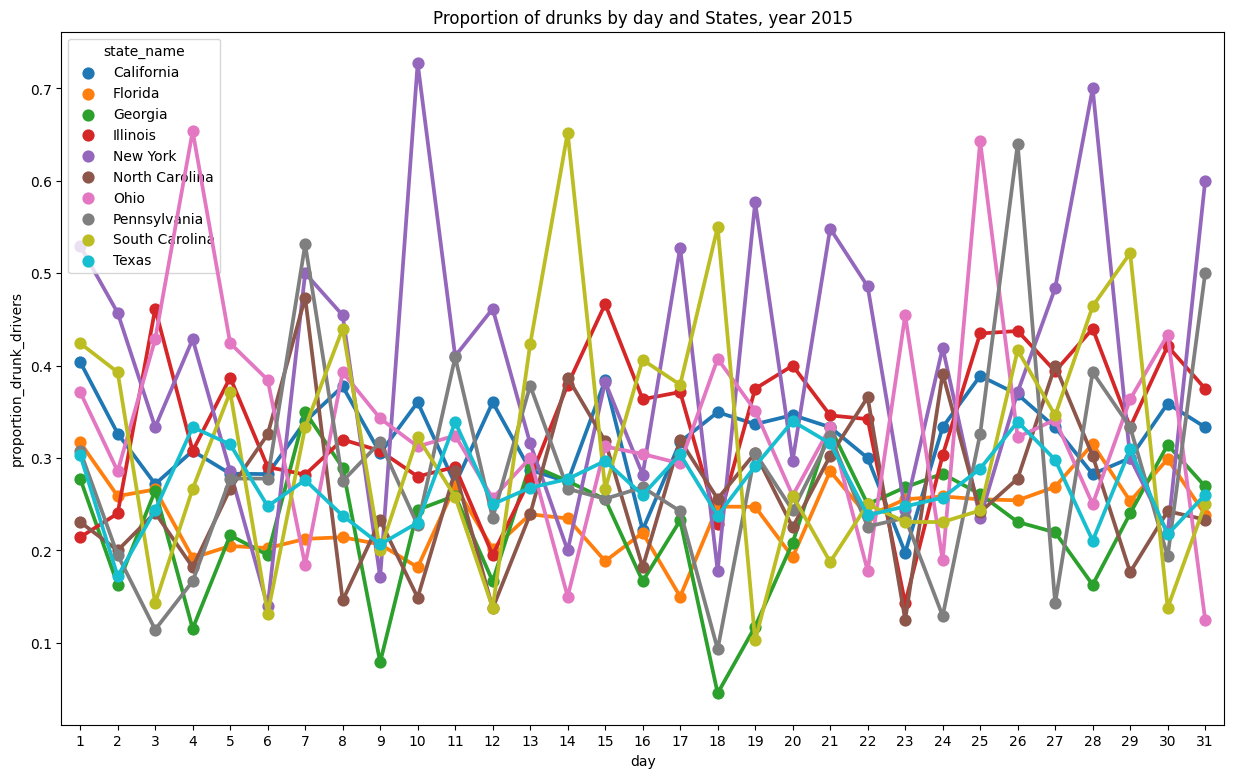

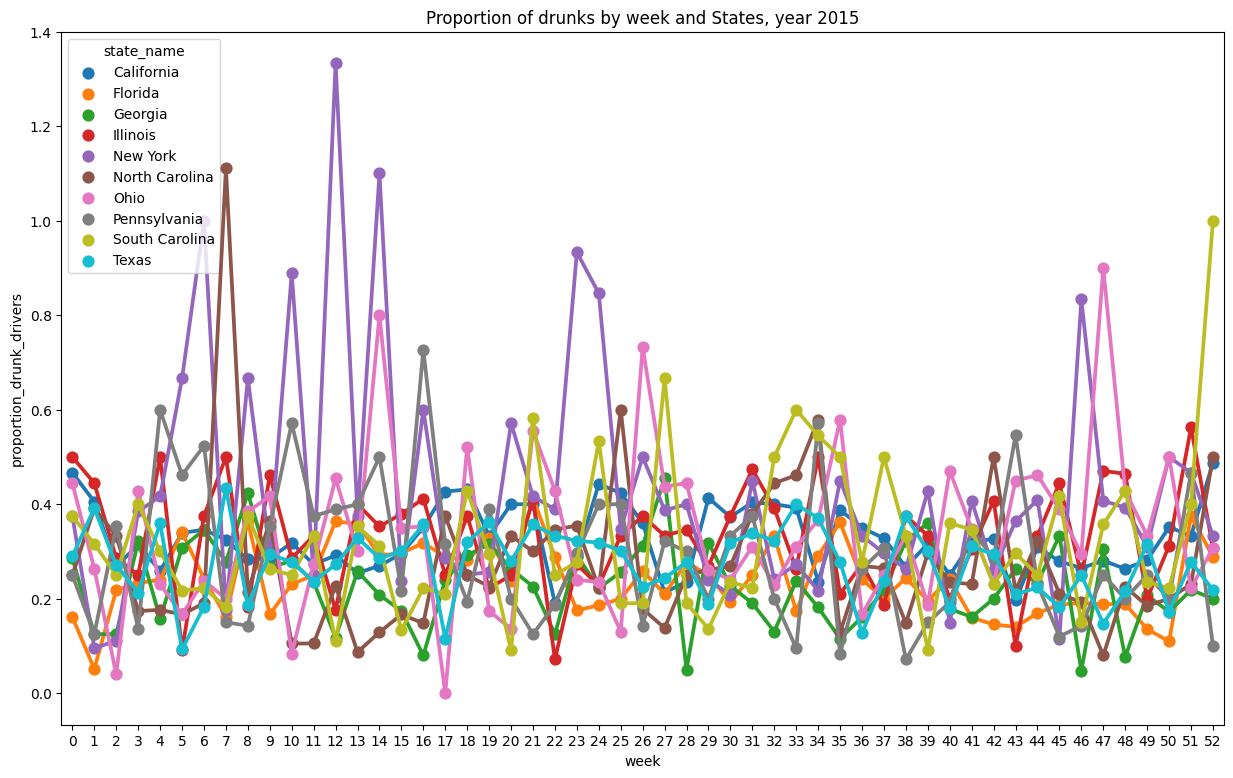

In [40]:
plot_drunks_by_accidents('month')
plot_drunks_by_accidents('day')
plot_drunks_by_accidents('week')

El valor de la proporción de personas ebrias en accidentes de transito en marzo en New York es inusual. El evento más grande que podría generar un valor inusual es el NY Gay Parade 2015.    